In [1]:
import itertools
from itertools import chain, combinations
from WMMSE_SSL_Kshot import k_shot_SSL_train_test
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# set the parameters
n = 3 # number of TP-UE pairs
num_train_samples = 10000 # total number of train samples
num_test_samples = 1000 # number of test samples
num_labeled_train_samples = 100 # number of labeled train samples (note that this parameter does not matter for the SSL pre-training phase)
batch_size = 64 # train/test batch size
hidden_layers = [128, 2] # backbone hidden layers
num_SSL_pretrain_epochs = 20 # number of SSL pre-training epochs
num_k_shot_epochs = 0 # number of supervised training epochs
tau = 0.1 # temperatue in contrastive loss
lr = 5e-2 # learning rate
device = 'cuda:0' # the device (cpu/gpu) to perform computations on

In [3]:
# pre-train the backbone using SSL
results = k_shot_SSL_train_test(n=n, num_train_samples=num_train_samples, num_test_samples=num_test_samples,
                                num_labeled_train_samples=num_labeled_train_samples, batch_size=batch_size,
                                hidden_layers=hidden_layers, num_SSL_pretrain_epochs=num_SSL_pretrain_epochs,
                                num_k_shot_epochs=num_k_shot_epochs, tau=tau, lr=lr, device=device
                               )

100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


In [4]:
# retrieve the embeddings and ground-truth power levels of the training samples
all_initial_embeddings = np.concatenate((results[2]['train-labeled'], results[2]['train-unlabeled']), axis=0)
all_embeddings = np.concatenate((results[3]['train-labeled'], results[3]['train-unlabeled']), axis=0)
all_groundtruth_PC_levels = np.concatenate((results[4]['train-labeled'], results[4]['train-unlabeled']), axis=0)

In [5]:
# derive the binary power control labels
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

cases = list(powerset(range(n)))[1:]
ncol = n
nrow = 2 ** n - 1
all_binaries = np.zeros((nrow, ncol), int)
all_binaries[np.arange(nrow).repeat([*map(len, cases)]), np.concatenate(cases)] = 1

all_binary_PC_labels = []
for y in all_groundtruth_PC_levels:
    distances = np.linalg.norm(all_binaries - y, ord=2, axis=1)
    all_binary_PC_labels.append(np.argmin(distances))
all_binary_PC_labels = np.array(all_binary_PC_labels)

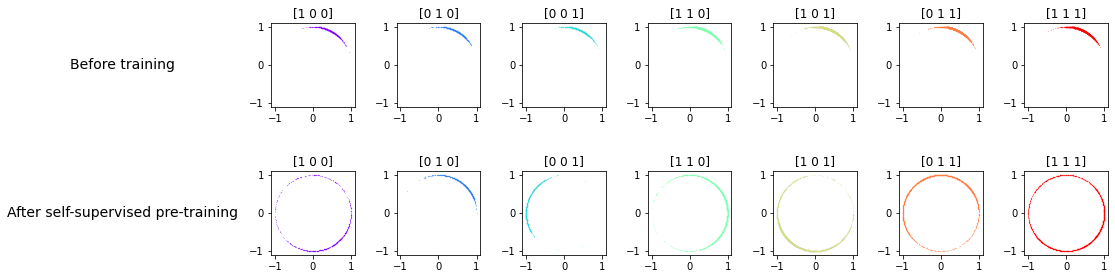

In [6]:
# plot the clusters before and after SSL pre-training
colors = cm.rainbow(np.linspace(0, 1, 2 ** n - 1))
plt_grid_size = int(np.ceil(np.sqrt(2 ** n - 1)))
fig, ax = plt.subplots(2, 2 ** n - 1, figsize=(15, 5))

for PC_label in range(2 ** n - 1):
    ax_row = 0
    ax_col = PC_label
    ax[ax_row, ax_col].clear()
    ax[ax_row, ax_col].set_title(str(all_binaries[PC_label]))
    sample_indices = np.where(all_binary_PC_labels == PC_label)[0]
    ax[ax_row, ax_col].scatter(all_initial_embeddings[sample_indices, 0],
                               all_initial_embeddings[sample_indices, 1],
                               s=0.01,
                               color=colors[PC_label]
                              )
    ax[ax_row, ax_col].set_xlim([-1.1, 1.1])
    ax[ax_row, ax_col].set_ylim([-1.1, 1.1])
    ax[ax_row, ax_col].set_aspect('equal')
    
    if PC_label == 0:
        ax[ax_row, ax_col].text(-5, -.1, 'Before training', fontsize=14, ha='center')
    
    ax_row = 1
    ax_col = PC_label
    ax[ax_row, ax_col].clear()
    ax[ax_row, ax_col].set_title(str(all_binaries[PC_label]))
    sample_indices = np.where(all_binary_PC_labels == PC_label)[0]
    ax[ax_row, ax_col].scatter(all_embeddings[sample_indices, 0],
                               all_embeddings[sample_indices, 1],
                               s=0.01,
                               color=colors[PC_label]
                              )
    ax[ax_row, ax_col].set_xlim([-1.1, 1.1])
    ax[ax_row, ax_col].set_ylim([-1.1, 1.1])
    ax[ax_row, ax_col].set_aspect('equal')
    if PC_label == 0:
        ax[ax_row, ax_col].text(-5, -.1, 'After self-supervised pre-training', fontsize=14, ha='center')
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)
plt.savefig('SSL_clusters.pdf', bbox_inches='tight')
plt.show()